# Chapter9 Advanced Deep Learning for Computer Vision

## 9.1 Three essential computer vision tasks

1. $Image$ $classification$ —Where the goal is to __assign one or more labels to an image__.
It may be either single-label classification (an image can only be in one category, excluding the others), or multi-label classification . For example, when you search
for a keyword on the Google Photos app, behind the scenes you’re querying a
very large multilabel classification model—one with over 20,000 different classes,
trained on millions of images.


2. $Image$ $segmentation$—Where the goal is to __“segment” or “partition” an image into
different areas__, with each area usually representing a category. For instance, when Zoom or Google Meet diplays a custom background behind you in a video call, it’s using an image segmentation model to
tell your face apart from what’s behind it, at pixel precision.


3. $Object$ $detection$—Where the goal is to __draw rectangles (called bounding boxes)
around objects of interest in an image, and associate each rectangle with a class__.
A self-driving car could use an object-detection model to monitor cars, pedestrians, and signs in view of its cameras, for instance.

## 9.2 An image segmentation example

 There are two different flavors of image segmentation that you should know about:

1. $Semantic$ $segmentation$, where __each pixel is independently classified into a semantic category__, like “cat.” If there are two cats in the image, the corresponding pixels are all mapped to the same generic “cat” category .


2. $Instance$ $segmentation$, which seeks __not only to classify image pixels by category,
but also to parse out individual object instances__. In an image with two cats in it,
instance segmentation would treat “cat 1” and “cat 2” as two separate classes of
pixels

We will use Semantic Segmentation 

http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [12]:
import os


target_dir = "E:\\Deep Learning with Python\Datas\\Ch_9_Semantic_Segmentation\\annotations\\trimaps\\"
input_dir = "E:\\Deep Learning with Python\Datas\\Ch_9_Semantic_Segmentation\\images\\"


input_img_paths =  sorted( [ os.path.join(input_dir,frame) 
                            for frame in os.listdir(input_dir) 
                             if frame.endswith('.jpg')  ]  )


target_paths =  sorted( [ os.path.join(target_dir,frame) 
                            for frame in os.listdir(target_dir) 
                             if frame.endswith('.png')  and  not frame.startswith(".")]  )


Now lets take a quick look at these inputs and mask

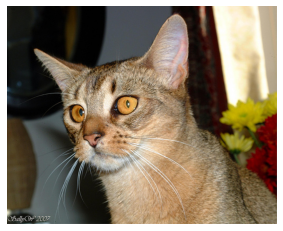

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.utils import load_img,img_to_array

plt.axis("off")
plt.imshow( load_img(input_img_paths[10])  )

In [14]:
def display_target(target_array):

    # The original labels are 1, 2, and 3. We subtract 1 so that the
    # labels range from 0 to 2, and then we multiply by 127 so that
    # the labels become 0 (black), 127 (gray), 254 (near-white)
    
    normalized_arrary = ( target_array.astype('uint8')-1 )*127
    plt.axis("off")
    plt.imshow(normalized_arrary[:,:,0])

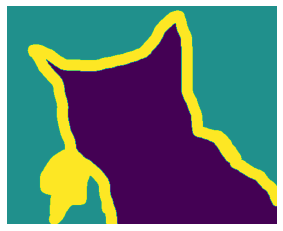

In [15]:
img = img_to_array( load_img(target_paths[10],color_mode='grayscale')) 


display_target(img)

Next, let’s load our inputs and targets into two NumPy arrays, and let’s split the arrays
into a training and a validation set. Since the dataset is very small, we can just load
everything into memory

In [69]:
import random 

img_size = (128,128)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path,target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path,target_size=img_size,color_mode='grayscale')   )
    img = img.astype("uint8")-1
    return img



In [70]:
path_to_input_image(input_img_paths[0]).shape

(128, 128, 3)

In [71]:
## Since img_size is a tuple, thus the other two dimension should be expressed as tuple as well
input_imgs = np.zeros( ((num_imgs ,)+ img_size + (3,)),dtype='float32'  )
targets = np.zeros( ((num_imgs ,)+ img_size + (1,)),dtype='uint8'  )



Load all images in the input_imgs
float32 array and their masks in the
targets uint8 array (same order). 

The inputs have three channels (RBG values)
and the targets have a single channel
(which contains integer labels).

In [72]:
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])
    

Reserve
1,000
samples for
validation

In [73]:
num_val_samples = 1000

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]

val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]


In [74]:
train_input_imgs.shape

(6390, 128, 128, 3)

Now it's time to define the model

In [75]:
from keras import layers

def get_model(img_size,num_classes):

    inputs  = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)
    
#########################################################################################################


    ### Set padding='same' to avoid influence of border padding on feature map size
    x = layers.Conv2D(filters=64,kernel_size=3,strides=2,activation='relu',padding='same')(x)
    x = layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(x)

    x = layers.Conv2D(filters=128,kernel_size=3,strides=2,activation='relu',padding='same')(x)
    x = layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(x)

    x = layers.Conv2D(filters=256,kernel_size=3,strides=2,activation='relu',padding='same')(x)
    x = layers.Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(x)
    
#########################################################################################################
    x = layers.Conv2DTranspose(256,3,activation='relu',padding='same')(x)
    x = layers.Conv2DTranspose(256,3,strides=2,activation='relu' ,padding='same')(x)

    x = layers.Conv2DTranspose(128,3,activation='relu',padding='same')(x)
    x = layers.Conv2DTranspose(128,3,strides=2,activation='relu' ,padding='same')(x)

    x = layers.Conv2DTranspose(64,3,activation='relu',padding='same')(x)
    x = layers.Conv2DTranspose(64,3,strides=2,activation='relu' ,padding='same')(x)

    
#########################################################################################################


    outputs = layers.Conv2D(num_classes,3,activation='softmax',padding='same')(x)

    model = keras.Model(inputs,outputs)

    return model


In [76]:
model = get_model(img_size=img_size,num_classes=3)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 conv2d_44 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 conv2d_45 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 256)       2951

1. $First$ $Half$:  __encode the images into smaller feature
 maps__, where each spatial location (or pixel) contains information about a large spatial
 chunk of the original image

2. $DownSample$: Here, we downsample __by adding strides__ to every other convolution layer. 
    
    We do this because, in the case of image segmentation, we care a lot about the __spatial location of information in the image__, since we need to produce per-pixel target masks as output of the model.
  
    When you do 2 × 2 max pooling, you are completely destroying location information within each pooling window: you return one scalar value per window, with zero knowledge of which of the four locations in the windows the value came from.
    
    Meanwhile, strided convolutions do a better job at downsampling feature maps
      while retaining location information

3. $Second$ $Half$ of the model is a stack of __Conv2DTranspose()__ layers.

    We need to apply a kind of __inverse__ of the transformations we’ve applied
    so far—something that will __upsample the feature maps__ instead of downsampling them.

    That’s the purpose of the Conv2DTranspose layer: you can think of it as a kind of convolution layer that __learns to upsample.__

    If you run this output through the layer __Conv2D Transpose(64, 3, strides=2, padding="same")__, you get back an output of shape __(100,100, 64)__, the same as the original.


In [77]:
model.compile(optimizer= keras.optimizers.RMSprop(),
            loss = keras.losses.SparseCategoricalCrossentropy(),
           
            )

callbacks = [keras.callbacks.ModelCheckpoint(
                            filepath="E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_9\\oxford_segmentation.keras"`,
                            monitor = 'val_loss',
                            save_best_only = True
                )]

In [80]:
history = model.fit(train_input_imgs[:3000],train_targets[:3000],
                    epochs=50,
                    callbacks = callbacks,
                    validation_data = (val_input_imgs,val_targets),
                    batch_size = 16,
                    verbose = 0
                    )

<AxesSubplot:>

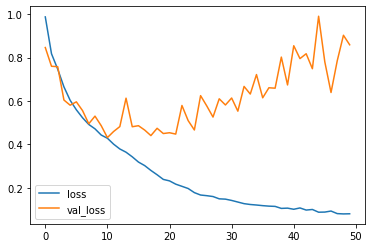

In [81]:
import pandas as pd 

df = pd.DataFrame(history.history)
df.plot()



You can see that we start overfitting midway, around epoch 25. 

Let’s reload our best
performing model according to the validation loss, and demonstrate how to use it to
predict a segmentation mask

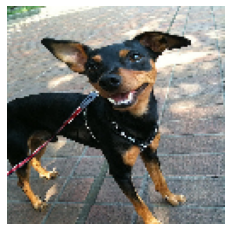

In [85]:
from keras.utils import array_to_img

model = keras.models.load_model("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_9\\oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]

plt.axis("off")
plt.imshow(array_to_img(test_image))


1/1 [==============================] - 0s 20ms/step
(128, 128, 3)


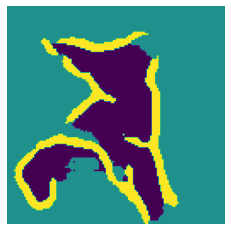

In [94]:

mask = model.predict(np.expand_dims(test_image,0))[0,:,:]

print(mask.shape)

def display_mask(pred):
    mask = np.argmax(pred,axis=-1)
    mask *=127
    plt.axis("off")
    plt.imshow(mask)


display_mask(mask)

You’re still lacking the essential
 mental models and thought processes that enable experts to make quick and accurate
 decisions about how to put together state-of-the-art models. To bridge that gap, you
 need to learn about architecture patterns. Let’s dive in.

## 9.3 Modern convnet architecture patterns

A model’s “architecture” is the sum of the choices that went into creating it:

These choices define the __hypothesis space__ of your model: the space of possible functions that
 gradient descent can search over, parameterized by the model’s weights. 
 
 Like feature
 engineering, a good hypothesis space encodes __prior knowledge__ that you have about the
 problem at hand and its solution

+  A good model architecture will
 accelerate learning and will enable your model to make efficient use of the training data
 available, reducing the need for large datasets.

+  A good model architecture is one that
 reduces the size of the search space or otherwise makes it easier to converge to a good point of the
 search space.

Just like feature engineering and data curation, model architecture is all
 about __making the problem simpler for gradient descent to solve__

In the following sections, we’ll review a few essential convnet architecture best
practices: in particular, 

$residual$ $connections$, $batch$ $normalization$, and $separable$ $convolutions$.

### 9.3.1 Modularity, hierarchy, and reuse (MHR)

$MHR$ $formula$:

If you want to make a complex system simpler, there’s a universal recipe you can
apply: 
+ Structure your amorphous soup of complexity into modules 

+ Organize the
modules into a $hierarchy$

+ $Reusing$ the same modules in multiple places as
appropriate (“reuse” is another word for abstraction in this context). 

+  Deep learning model architecture is primarily about making clever use o 
 modularity, hierarchy, and reuse. You’ll notice that all popular convnet architectures
 are not only structured into layers, they’re structured into repeated groups of layers


+ Most convnets often feature pyramid-like structures (feature hierarchies).Deeper hierarchies are intrinsically good because they encourage feature reuse, and
 therefore abstraction.

If you read lots of deep learning papers, you will notice that they’re
 often optimized for peer review in both style and content in ways that actively hurt
 clarity of explanation and reliability of results.


Always ask, “Could there be a simpler
 explanation? Is this added complexity really necessary? Why?

### 9.3.2 Residual Connections

$Vanishing Gradients$: If your function chain is too
 deep, this noise starts overwhelming gradient information, and backpropagation
 stops working. Your model won’t train at all. 

The easiest way to implement this is to use a __residual connection__. 

It’s dead easy: __just add the
 input of a layer or block of layers back to its output__ 


The residual connection acts as an $information$ $shortcut$ around destructive or noisy blocks

Listing 9.1 A residual connection in pseudocode

In [100]:
# import tensorflow as tf

# x = tf.random.uniform(shape=(1,3))
# residual = x 
# x = block(x)
# x = add([x,residual])

In such cases, use a 1 × 1 Conv2D layer with no activation to linearly project the
 residual to the desired output shape.

Listing 9.2 Residual block where the number of filters changes

In [102]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(32,32,3))


x = layers.Conv2D(32,3,activation='relu')(inputs)

# Set
# aside the
# residual
residual = x 

# This is the layer around which we create
# a residual connection: it increases the
# number of output filers from 32 to 64.
# Note that we use padding="same"
# to avoid downsampling
# due to padding.
x = layers.Conv2D(64,3,activation='relu',padding='same')(x)

# The residual only had 32 
# filters, so we use a 1 × 1
# Conv2D to project it to the 
# correct shape.
residual = layers.Conv2D(64,1)(residual)

# Now the block output and the
# residual have the same shape
# and can be added.
x = layers.add([x,residual])


Listing 9.3 Case where the target block includes a max pooling layer

In [103]:

inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, 3, activation="relu")(inputs)

## Set aside the residual
residual = x 

# This is the block of two layers around which
# we create a residual connection: it includes a
# 2 × 2 max pooling layer. Note that we use
# padding="same" in both the convolution
# layer and the max pooling layer to avoid
# downsampling due to padding.

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x) 
x = layers.MaxPooling2D(2, padding="same")(x) 


# We use strides=2 in the residual 
# projection to match the downsampling 
# created by the max pooling layer.
residual = layers.Conv2D(64, 1, strides=2)(residual) 


# Now the block output and the residual 
# have the same shape and can be added.

x = layers.add([x, residual])

To make these ideas more concrete, here’s an example of a simple convnet structured
into a series of blocks, each made of two convolution layers and one optional max
pooling layer, with a residual connection around each block

In [104]:

# Utility function to apply a 
# convolutional block with a 
# residual connection, with an 
# option to add max pooling
def residual_block(x,filters,pooling= False ):
    residual = x 

    x = layers.Conv2D(filters,3,activation='relu',padding='same')(x)
    x = layers.Conv2D(filters,3,activation='relu',padding='same')(x)

    if pooling:
        
        x = layers.MaxPooling2D(2,padding='same')(x)

        # If we use max 
        # pooling, we 
        # add a strided 
        # convolution to 
        # project the 
        # residual to the 
        # expected shape.
        residual = layers.Conv2D(filters,1,strides=2)(residual)

    elif filters != residual.shape[-1]:

        # If we don’t use max 
        # pooling, we only project 
        # the residual if the 
        # number of channels 
        # has changed.
        residual = layers.Conv2D(filters,1)(residual)
    
    x = layers.add([x,residual])

    return x 

In [106]:
inputs = keras.Input(shape=(32,32,3))
x = layers.Rescaling(1./255)(inputs)


#First Block
x = residual_block(x,filters=32,pooling=True)
#Second Block
x = residual_block(x,filters=64,pooling=True)

# The last block doesn’t need a max
#  pooling layer, since we will apply
#  global average pooling right after it
x = residual_block(x,filters=128,pooling=False)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(1,activation="sigmoid")(x)

model = keras.Model(inputs,outputs)



In [107]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_9 (Rescaling)        (None, 32, 32, 3)    0           ['input_13[0][0]']               
                                                                                                  
 conv2d_61 (Conv2D)             (None, 32, 32, 32)   896         ['rescaling_9[0][0]']            
                                                                                                  
 conv2d_62 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_61[0][0]']              
                                                                                            